![](images/FirstSlide.PNG)

# ATT&CK - APT29 Evals Datasets

![](images/APT29.PNG)

![](images/WhatIsSpark.PNG)

![](images/CoreClasses.PNG)

![](images/CoreClassesToday.PNG)

### 1. Importing Python Libraries

* **pyspark** modules and classes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql.functions import length, concat ,concat_ws

* **Complementary** libraries

In [2]:
import pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
import requests

from openhunt import ossem, descriptiveStatistics as ds, visualizations as vis

import warnings
warnings.filterwarnings('ignore')

### 2. Initializing SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.caseSensitive", "true")

### 3. Importing and Reading Datasets: Host and Network

* **Host** Data - **Day 1**

In [4]:
!unzip datasets/apt29_evals_day1_manual.zip

Archive:  apt29_evals_day1_manual.zip
  inflating: apt29_evals_day1_manual_2020-05-01225525.json  


In [5]:
host_day1 = spark.read.json('datasets/apt29_evals_day1_manual_2020-05-01225525.json')

print(type(host_day1))
host_day1.select('@timestamp','Channel','EventID').show(5, truncate = False)

<class 'pyspark.sql.dataframe.DataFrame'>
+------------------------+------------------------------------+-------+
|@timestamp              |Channel                             |EventID|
+------------------------+------------------------------------+-------+
|2020-05-02T02:55:26.493Z|Microsoft-Windows-Sysmon/Operational|10     |
|2020-05-02T02:55:26.493Z|Microsoft-Windows-Sysmon/Operational|10     |
|2020-05-02T02:55:26.493Z|Microsoft-Windows-Sysmon/Operational|10     |
|2020-05-02T02:55:26.494Z|Microsoft-Windows-Sysmon/Operational|10     |
|2020-05-02T02:55:26.494Z|Microsoft-Windows-Sysmon/Operational|10     |
+------------------------+------------------------------------+-------+
only showing top 5 rows



* **Host** Data - **Day 2**

In [6]:
!unzip datasets/apt29_evals_day2_manual.zip

Archive:  apt29_evals_day2_manual.zip
  inflating: apt29_evals_day2_manual_2020-05-02035409.json  


In [7]:
host_day2 = spark.read.json('datasets/apt29_evals_day2_manual_2020-05-02035409.json')

print(type(host_day2))
host_day2.select('@timestamp','Channel','EventID').show(5, truncate = False)

<class 'pyspark.sql.dataframe.DataFrame'>
+------------------------+------------------------------------+-------+
|@timestamp              |Channel                             |EventID|
+------------------------+------------------------------------+-------+
|2020-05-02T07:54:05.402Z|Microsoft-Windows-Sysmon/Operational|13     |
|2020-05-02T07:54:05.402Z|Microsoft-Windows-Sysmon/Operational|13     |
|2020-05-02T07:54:05.402Z|Microsoft-Windows-Sysmon/Operational|13     |
|2020-05-02T07:54:05.402Z|Microsoft-Windows-Sysmon/Operational|12     |
|2020-05-02T07:54:05.402Z|Microsoft-Windows-Sysmon/Operational|13     |
+------------------------+------------------------------------+-------+
only showing top 5 rows



* **Network** data - **Day 1**

In [8]:
zeekUrl_day1 = 'https://raw.githubusercontent.com/OTRF/detection-hackathon-apt29/master/datasets/day1/zeek/combined_zeek.log'
zeekLogs_day1 = requests.get(zeekUrl_day1)
zeekDf_day1 = pd.read_json(zeekLogs_day1.text, lines = True)

print(type(zeekDf_day1))
zeekDf_day1.head()

<class 'pandas.core.frame.DataFrame'>


,@stream,@system,@proc,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,...,is_64bit,uses_aslr,uses_dep,uses_code_integrity,uses_seh,has_import_table,has_export_table,has_cert_table,has_debug_data,section_names
0,conn,bobs.bigwheel.local,zeek,1.588205e+09,Cvf4XX17hSAgXDdGEd,10.0.1.6,54243.0,10.0.0.4,53.0,udp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,conn,bobs.bigwheel.local,zeek,1.588205e+09,CJ21Le4zsTUcyKKi98,10.0.1.6,56880.0,10.0.0.4,445.0,tcp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,conn,bobs.bigwheel.local,zeek,1.588205e+09,CnOP7t1eGGHf6LFfuk,10.0.1.6,65108.0,10.0.0.4,53.0,udp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,conn,bobs.bigwheel.local,zeek,1.588205e+09,CvxbPE3MuO7boUdSc8,10.0.1.6,138.0,10.0.1.255,138.0,udp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,conn,bobs.bigwheel.local,zeek,1.588205e+09,CuRbE21APSQo2qd6rk,10.0.1.6,123.0,10.0.0.4,123.0,udp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's convert this **pandas** dataframe into a **spark** dataframe.

In [9]:
columnsToChangeType_day1= zeekDf_day1.select_dtypes(include=[object]).columns.to_list()
dictionary_day1 = {i : 'str' for i in columnsToChangeType_day1}
zeekDf_day1 = zeekDf_day1.astype(dictionary_day1)

In [10]:
zeekSpark_day1 = spark.createDataFrame(zeekDf_day1)

print(type(zeekSpark_day1))
zeekSpark_day1.select('id_orig_h','id_orig_p','id_resp_h','id_resp_p').show(5, truncate = False)

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+---------+----------+---------+
|id_orig_h|id_orig_p|id_resp_h |id_resp_p|
+---------+---------+----------+---------+
|10.0.1.6 |54243.0  |10.0.0.4  |53.0     |
|10.0.1.6 |56880.0  |10.0.0.4  |445.0    |
|10.0.1.6 |65108.0  |10.0.0.4  |53.0     |
|10.0.1.6 |138.0    |10.0.1.255|138.0    |
|10.0.1.6 |123.0    |10.0.0.4  |123.0    |
+---------+---------+----------+---------+
only showing top 5 rows



* **Network** data - **Day 2**

In [11]:
zeekUrl_day2 = 'https://raw.githubusercontent.com/OTRF/detection-hackathon-apt29/master/datasets/day2/zeek/combined_zeek.log'
zeekLogs_day2 = requests.get(zeekUrl_day2)
zeekDf_day2 = pd.read_json(zeekLogs_day2.text, lines = True)

print(type(zeekDf_day2))
zeekDf_day2.head()

<class 'pandas.core.frame.DataFrame'>


,@stream,@system,@proc,ts,ts_delta,peer,gaps,acks,percent_lost,uid,...,certificate_not_valid_before,certificate_not_valid_after,certificate_key_alg,certificate_sig_alg,certificate_key_type,certificate_key_length,certificate_exponent,server_name,next_protocol,san_dns
0,capture_loss,test-nsm,zeek,1.588318e+09,936.076895,zeek,9.0,1195.0,0.753138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,capture_loss,test-nsm,zeek,1.588318e+09,814.636130,zeek,2.0,945.0,0.211640,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,conn,test-nsm,zeek,1.588317e+09,NaN,NaN,NaN,NaN,NaN,CyLse01Jig9yHofDXc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,conn,test-nsm,zeek,1.588317e+09,NaN,NaN,NaN,NaN,NaN,C55VWq1ibAOPBspBn4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,conn,test-nsm,zeek,1.588317e+09,NaN,NaN,NaN,NaN,NaN,CD0rgw3qZTWQNLB1ik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's convert this **pandas** dataframe into a **spark** dataframe.

In [12]:
columnsToChangeType_day2= zeekDf_day2.select_dtypes(include=[object]).columns.to_list()
dictionary_day2 = {i : 'str' for i in columnsToChangeType_day2}
zeekDf_day2 = zeekDf_day2.astype(dictionary_day2)

In [13]:
zeekSpark_day2 = spark.createDataFrame(zeekDf_day2)

print(type(zeekSpark_day2))
zeekSpark_day2.select('id_orig_h','id_orig_p','id_resp_h','id_resp_p').show(5, truncate = False)

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+---------+---------+---------+
|id_orig_h|id_orig_p|id_resp_h|id_resp_p|
+---------+---------+---------+---------+
|nan      |NaN      |nan      |NaN      |
|nan      |NaN      |nan      |NaN      |
|10.0.1.5 |55979.0  |10.0.0.4 |53.0     |
|10.0.1.5 |56259.0  |10.0.0.4 |53.0     |
|10.0.1.5 |64294.0  |10.0.0.4 |53.0     |
+---------+---------+---------+---------+
only showing top 5 rows



### 4. Creating a Temporary SQL View

In [14]:
host_day1.createTempView("apt29HostDay1")
host_day2.createTempView("apt29HostDay2")

zeekSpark_day1.createTempView("apt29NetworkDay1")
zeekSpark_day2.createTempView("apt29NetworkDay2")

### 5. Now we are finally ready to start exploring our data!!

![](images/AreWeReady.PNG)

### Let's first check something really basic:

![](images/dataType1.PNG)

![](images/dataType2.PNG)

### a) What sources of data do we have for hosts on day 1?

Let's select all the data for event field **Channel**:

In [15]:
channel_host_day1 = spark.sql(
    '''
SELECT Channel
FROM apt29HostDay1
                          ''')
channel_host_day1.show(5, truncate = False)

+------------------------------------+
|Channel                             |
+------------------------------------+
|Microsoft-Windows-Sysmon/Operational|
|Microsoft-Windows-Sysmon/Operational|
|Microsoft-Windows-Sysmon/Operational|
|Microsoft-Windows-Sysmon/Operational|
|Microsoft-Windows-Sysmon/Operational|
+------------------------------------+
only showing top 5 rows



This is a **Categorical** variable, so a **stack counting** operation would be helpful:

In [16]:
channel_host_day1 = spark.sql(
    '''
SELECT Channel, count(*) as count
FROM apt29HostDay1

GROUP BY Channel
ORDER BY count DESC
                          ''')
channel_host_day1.show(5, truncate = False)

+----------------------------------------+------+
|Channel                                 |count |
+----------------------------------------+------+
|Microsoft-Windows-Sysmon/Operational    |143884|
|Security                                |28627 |
|security                                |12375 |
|Microsoft-Windows-PowerShell/Operational|5694  |
|Windows PowerShell                      |5285  |
+----------------------------------------+------+
only showing top 5 rows



If you are more a **visual** person :D

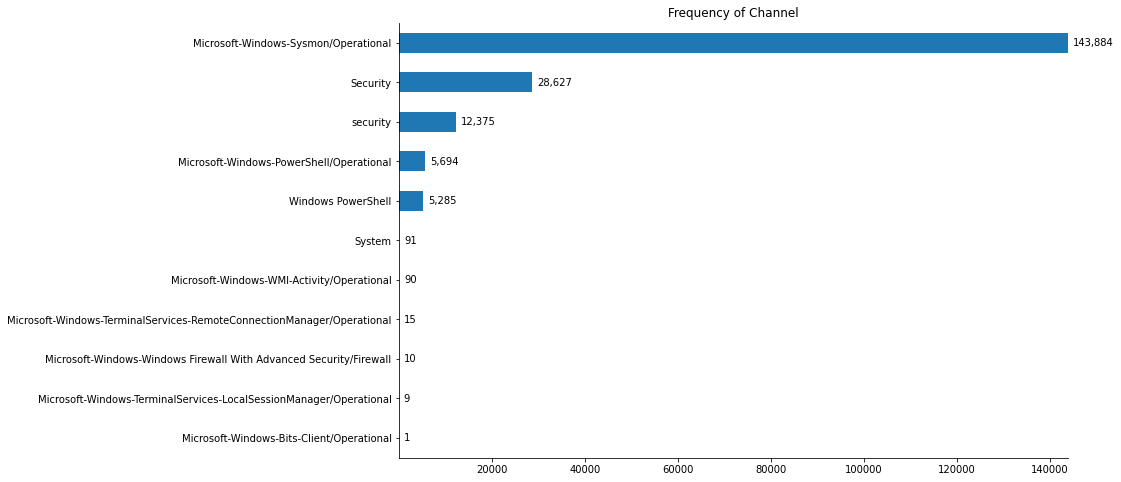

In [17]:
vis.barh_chart(channel_host_day1,'count','Channel','Frequency of Channel')

### b) What Sysmon logs do we have for hosts on day 1?

Let's use the **WHERE** operator to **filter** our dataset:

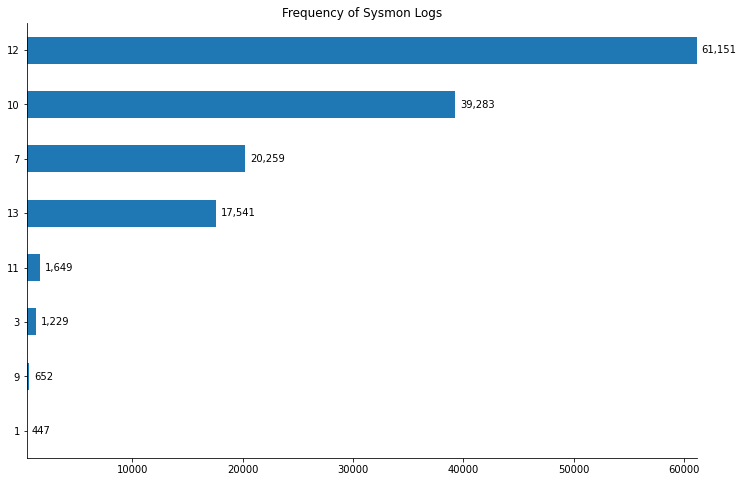

In [18]:
sysmon_host_day1 = spark.sql(
    '''
SELECT EventID, count(*) as count
FROM apt29HostDay1
WHERE Channel = 'Microsoft-Windows-Sysmon/Operational'

GROUP BY EventID
ORDER BY count DESC
                          ''')

vis.barh_chart(spark.createDataFrame(sysmon_host_day1.head(8)),'count','EventID','Frequency of Sysmon Logs')

### c) Let's analyze information of Sysmon 1: Process Creation

What are the event fields for **Sysmon 1**? Let's get this information from OSSEM :D

In [19]:
ossem.getEventDf(platform = 'windows', provider = 'sysmon', event = 'event-1')

,event_code,title,standard_name,standard_type,name,type,description,sample_value
0,1,Event ID 1: Process creation,tag,TBD,RuleName,string,custom tag mapped to event. i.e ATT&CK techniq...,T1114
1,1,Event ID 1: Process creation,event_date_creation,TBD,UtcTime,date,Time in UTC when event was created,4/11/18 5:25
2,1,Event ID 1: Process creation,process_guid,TBD,ProcessGuid,string,Process Guid of the process that got spawned/c...,{A98268C1-9C2E-5ACD-0000-0010396CAB00}
3,1,Event ID 1: Process creation,process_id,TBD,ProcessId,integer,Process ID used by the os to identify the crea...,4756
4,1,Event ID 1: Process creation,process_path,TBD,Image,string,File path of the process being spawned/created...,C:\Windows\System32\conhost.exe
5,1,Event ID 1: Process creation,file_version,TBD,FileVersion,string,Version of the image associated with the main ...,10.0.16299.15 (WinBuild.160101.0800)
6,1,Event ID 1: Process creation,file_description,TBD,Description,string,Description of the image associated with the m...,Console Window Host
7,1,Event ID 1: Process creation,file_product,TBD,Product,string,Product name the image associated with the mai...,Microsoft® Windows® Operating System
8,1,Event ID 1: Process creation,file_company,TBD,Company,string,Company name the image associated with the mai...,Microsoft Corporation
9,1,Event ID 1: Process creation,file_name_original,TBD,OriginalFileName,string,original file name,wuauclt.exe


Now that we know the fields' names of **Sysmon 1**, let's query its info:

In [20]:
sysmon1 = spark.sql(
    '''
SELECT User, LogonId, ProcessId, Image, CommandLine, ParentProcessId, ParentImage, ParentCommandLine 
FROM apt29HostDay1
WHERE Channel = "Microsoft-Windows-Sysmon/Operational"
    AND EventID = 1
                          ''')
sysmon1.show(1, truncate = False, vertical = True)

-RECORD 0--------------------------------------------------------
 User              | DMEVALS\pbeesly                             
 LogonId           | 0x3731f3                                    
 ProcessId         | 8524                                        
 Image             | C:\ProgramData\victim\â€®cod.3aka3.scr      
 CommandLine       | "C:\ProgramData\victim\â€®cod.3aka3.scr" /S 
 ParentProcessId   | 4440                                        
 ParentImage       | C:\Windows\explorer.exe                     
 ParentCommandLine | C:\windows\Explorer.EXE                     
only showing top 1 row



All the fields contain **categorical data**, so we can continue doing stack counting operations. Let's try something different: Let's calculate the **length of characters** of the **CommandLine** field.

In [21]:
sysmon1 = spark.sql(
    '''
SELECT User, LogonId, ProcessId, Image, CommandLine, ParentProcessId, ParentImage, ParentCommandLine,
        length(CommandLine) as CommandLineLength
FROM apt29HostDay1
WHERE Channel = "Microsoft-Windows-Sysmon/Operational"
    AND EventID = 1
                          ''')
sysmon1.show(1,truncate = False, vertical = True)

-RECORD 0--------------------------------------------------------
 User              | DMEVALS\pbeesly                             
 LogonId           | 0x3731f3                                    
 ProcessId         | 8524                                        
 Image             | C:\ProgramData\victim\â€®cod.3aka3.scr      
 CommandLine       | "C:\ProgramData\victim\â€®cod.3aka3.scr" /S 
 ParentProcessId   | 4440                                        
 ParentImage       | C:\Windows\explorer.exe                     
 ParentCommandLine | C:\windows\Explorer.EXE                     
 CommandLineLength | 43                                          
only showing top 1 row



Now we have a **Numerical** variable in our dataframe. What do we know about this new variable?

* Before we continue with our analysis, let's review two basic but important concepts: **Mean** and **Standard Deviation**:

![](images/average.PNG)

![](images/average2.PNG)

![](images/average3.PNG)

We can use **descriptive** method to calculate basic statistics

In [22]:
sysmon1.select('CommandLineLength').describe().show()

+-------+-----------------+
|summary|CommandLineLength|
+-------+-----------------+
|  count|              446|
|   mean| 82.2152466367713|
| stddev|337.3961141365345|
|    min|                5|
|    max|             7106|
+-------+-----------------+



We can also use **numStats** method from openhunt to calculate more basic statistics

In [23]:
ds.numStats(sysmon1,'CommandLineLength')

Summary of Descriptive Statistics -  CommandLineLength
**********************************************************
Count of values          :  446
Count of Null values     :  1
Central tendency:-----------------------------------------
Mean(Average)            :  82.22
Median(Percentile 25)    :  55.0
Min, Max, and Percentiles:--------------------------------
Minimum                  :  5
Maximum                  :  7106
Percentile 25 (Q1)       :  48.0
Percentile 75 (Q3)       :  68.0
Variation:------------------------------------------------
Standard Deviation       :  337.4
Range                    :  7101
Interquartile Range (IQR):  20.0
Shape:----------------------------------------------------
Skewness                 :  20.31
Kurtosis                 :  420.01
**********************************************************


,Statistic,Values
0,count,446.000000
1,Count Null Values,1.000000
2,mean,82.215247
3,median,55.000000
4,min,5.000000
5,max,7106.000000
6,percentile25,48.000000
7,percentile75,68.000000
8,stddev,337.396114
9,range,7101.000000


Can we do this statistical analysis in a more **visual** way? Let's check a couple of visualizations :D

A **histogram**

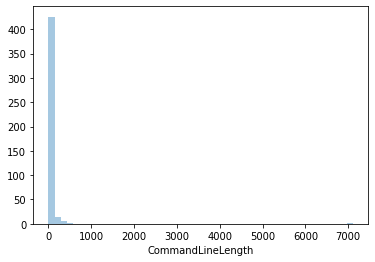

In [24]:
vis.histogram(sysmon1,'CommandLineLength')

A **Boxplot***

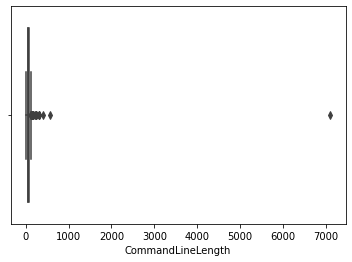

In [25]:
vis.box_plot(sysmon1,'CommandLineLength')

How can we improve our graphs? Let's add more contex to our SQL query:

In [26]:
sysmon1 = spark.sql(
    '''
SELECT User, LogonId, ProcessId, Image, CommandLine, ParentProcessId, ParentImage, ParentCommandLine,
        length(CommandLine) as CommandLineLength
FROM apt29HostDay1
WHERE Channel = "Microsoft-Windows-Sysmon/Operational"
    AND EventID = 1
    AND length(CommandLine) <1000
                          ''')

Let's graph our **Histogram** again!!

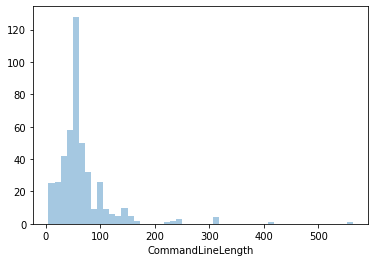

In [27]:
vis.histogram(sysmon1,'CommandLineLength')

And our **Boxplot** also!!

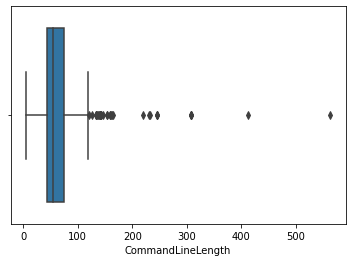

In [28]:
vis.box_plot(sysmon1,'CommandLineLength')

And what about the **atipic** values or outliers for the CommandLine lenght? Let's filter the one  :D

In [29]:
sysmon1 = spark.sql(
    '''
SELECT User, LogonId, ProcessId, Image, CommandLine, ParentProcessId, ParentImage, ParentCommandLine,
        length(CommandLine) as CommandLineLength
FROM apt29HostDay1
WHERE Channel = "Microsoft-Windows-Sysmon/Operational"
    AND EventID = 1
    AND length(CommandLine) > 7000
                          ''')
print('We have ', sysmon1.count(), ' records')
sysmon1.show(truncate = False, vertical = True)

We have  1  records
-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This event might represent the **potential execution** of a **PowerSheel script** **:O**

Let's get all the **Sysmon** events related to its **ProcessId 8704** as a Child

In [30]:
process8704 = spark.sql(
    '''
SELECT EventID , count(*) as count
FROM apt29HostDay1
WHERE ProcessId = 8704

GROUP BY EventID
ORDER BY count DESC
                          ''')
process8704.show(truncate = False)

+-------+-----+
|EventID|count|
+-------+-----+
|12     |236  |
|7      |84   |
|11     |3    |
|23     |3    |
|17     |2    |
|13     |2    |
|5      |1    |
|1      |1    |
|18     |1    |
|10     |1    |
+-------+-----+



It is common to start looking for **PowerShell** events because it is a tool that **enables** a lot of other **techiques**. We should also focus on the events related to this process to identify other behaviors and techniques.
* Notes: 12 (Registry creation and deletion), 7 (Image Loaded), 11 (File Creation), 23 (File Delete), 17 (Pipe Created), 13 (Registry Modification), 1 (Process Creation), 10 (Process Access), 18 (Pipe Connected), 5 (Process Terminated)


### d) Let's now analyze information of Sysmon 3: Network Connection

Let's query the info for this event and calculate the **most frequent** pair or IPs (Source -> Destination):

In [31]:
sysmon3 = spark.sql(
    '''
SELECT concat_ws(' <--> ',SourceIp,DestinationIp) as SourceDestinationIP, count(*) as count
FROM apt29HostDay1
WHERE Channel = "Microsoft-Windows-Sysmon/Operational"
    AND EventID = 3
    AND NOT SourceIp = DestinationIp
    AND (SourceIp = "10.0.1.4" OR SourceIp = "10.0.1.5" OR SourceIp = "10.0.1.6")
    
GROUP BY concat_ws(' <--> ',SourceIp,DestinationIp)
ORDER BY count DESC
                          ''')
sysmon3.show(truncate = False)

+-----------------------------+-----+
|SourceDestinationIP          |count|
+-----------------------------+-----+
|10.0.1.6 <--> 192.168.0.4    |348  |
|10.0.1.4 <--> 10.0.0.4       |160  |
|10.0.1.6 <--> 10.0.0.4       |88   |
|10.0.1.4 <--> 10.0.1.6       |34   |
|10.0.1.5 <--> 10.0.0.4       |18   |
|10.0.1.4 <--> 192.168.0.4    |8    |
|10.0.1.4 <--> 168.61.186.235 |7    |
|10.0.1.4 <--> 23.4.15.75     |4    |
|10.0.1.4 <--> 52.167.250.154 |4    |
|10.0.1.4 <--> 23.56.173.48   |4    |
|10.0.1.4 <--> 10.0.1.255     |4    |
|10.0.1.6 <--> 52.167.250.154 |4    |
|10.0.1.4 <--> 192.168.0.5    |3    |
|10.0.1.5 <--> 10.0.1.255     |3    |
|10.0.1.6 <--> 10.0.1.255     |3    |
|10.0.1.4 <--> 239.255.255.250|2    |
|10.0.1.4 <--> 72.21.81.200   |2    |
|10.0.1.4 <--> 40.90.137.124  |1    |
|10.0.1.5 <--> 52.114.159.32  |1    |
|10.0.1.6 <--> 52.114.159.32  |1    |
+-----------------------------+-----+
only showing top 20 rows



### e) So, Is this all the potential of PySpark.SQL?... "JOIN" me in learning more about it :D

Let's take a look at the **Lateral Movement** tactic accomplished during Day 1:

![](images/lateral1.PNG)

![](images/lateral2.PNG)

Let's query the host data for day 1 using **Security 4624 (Account Successfully Logged On)** event as a reference:

In [32]:
lateralMovement = spark.sql(
    '''
    SELECT
        o.Hostname, o.EventID, o.SubjectUserName, o.SubjectLogonId,
        a.TargetUserName, a.TargetLogonId, a.IpAddress
    FROM apt29HostDay1 o
    INNER JOIN (
        SELECT Hostname, TargetUserName, TargetLogonId, IpAddress
        FROM apt29HostDay1
        WHERE LOWER(Channel) = 'security'
            AND EventID = 4624
            AND LogonType = 3
            AND NOT IpAddress LIKE "%-%"
            AND NOT TargetUserName LIKE "%$"          
        ) a
    ON o.SubjectLogonId = a.TargetLogonId
    WHERE LOWER(o.Channel) = 'security'
    ''')

print("There are ", lateralMovement.count(), ' records.')
lateralMovement.show(truncate = False)

There are  94  records.
+---------------------+-------+---------------+--------------+--------------+-------------+---------+
|Hostname             |EventID|SubjectUserName|SubjectLogonId|TargetUserName|TargetLogonId|IpAddress|
+---------------------+-------+---------------+--------------+--------------+-------------+---------+
|NEWYORK.dmevals.local|5140   |pbeesly        |0x5dd594      |pbeesly       |0x5dd594     |10.0.1.4 |
|NEWYORK.dmevals.local|5145   |pbeesly        |0x5dd594      |pbeesly       |0x5dd594     |10.0.1.4 |
|NEWYORK.dmevals.local|4661   |pbeesly        |0x5dd594      |pbeesly       |0x5dd594     |10.0.1.4 |
|NEWYORK.dmevals.local|4658   |pbeesly        |0x5dd594      |pbeesly       |0x5dd594     |10.0.1.4 |
|NASHUA.dmevals.local |4672   |pbeesly        |0x861a79      |pbeesly       |0x861a79     |10.0.1.4 |
|NASHUA.dmevals.local |5140   |pbeesly        |0x861a79      |pbeesly       |0x861a79     |10.0.1.4 |
|NASHUA.dmevals.local |5145   |pbeesly        |0x861a79   

Let's take a look at **Security 5145 (A network share object was checked)** event:

In [33]:
lateralMovement = spark.sql(
    '''
    SELECT
        o.Hostname, o.EventID, o.SubjectUserName, o.SubjectLogonId, o.ShareName, o.ShareLocalPath, o.RelativeTargetName,
        a.TargetUserName, a.TargetLogonId, a.IpAddress
    FROM apt29HostDay1 o
    INNER JOIN (
        SELECT Hostname, TargetUserName, TargetLogonId, IpAddress
        FROM apt29HostDay1
        WHERE LOWER(Channel) = 'security'
            AND EventID = 4624
            AND LogonType = 3
            AND NOT IpAddress LIKE "%-%"
            AND NOT TargetUserName LIKE "%$"          
        ) a
    ON o.SubjectLogonId = a.TargetLogonId
    WHERE LOWER(o.Channel) = 'security'
        AND EventID = 5145
    ''')

print("There are ", lateralMovement.count(), ' records.')
lateralMovement.show(45, truncate = False)

There are  45  records.
+---------------------+-------+---------------+--------------+----------+--------------+-----------------------------+--------------+-------------+---------+
|Hostname             |EventID|SubjectUserName|SubjectLogonId|ShareName |ShareLocalPath|RelativeTargetName           |TargetUserName|TargetLogonId|IpAddress|
+---------------------+-------+---------------+--------------+----------+--------------+-----------------------------+--------------+-------------+---------+
|NEWYORK.dmevals.local|5145   |pbeesly        |0x5dd594      |\\*\IPC$  |null          |samr                         |pbeesly       |0x5dd594     |10.0.1.4 |
|NASHUA.dmevals.local |5145   |pbeesly        |0x861a79      |\\*\ADMIN$|\??\C:\windows|Temp\python.exe              |pbeesly       |0x861a79     |10.0.1.4 |
|NASHUA.dmevals.local |5145   |pbeesly        |0x861a79      |\\*\ADMIN$|\??\C:\windows|Temp                         |pbeesly       |0x861a79     |10.0.1.4 |
|NASHUA.dmevals.local |5145 

Now we have **more context** to add in our data model :D

![](images/lateral3.PNG)

### f) Finally... let's check some network data!! :D

How many byters were transferred from hosts on days 1?

In [34]:
bytes_from_host_day1 = spark.sql(
    '''
SELECT orig_bytes
FROM apt29NetworkDay1
                          ''')

ds.numStats(bytes_from_host_day1,'orig_bytes')

Summary of Descriptive Statistics -  orig_bytes
**********************************************************
Count of values          :  577
Count of Null values     :  1563
Central tendency:-----------------------------------------
Mean(Average)            :  26483.55
Median(Percentile 25)    :  997.0
Min, Max, and Percentiles:--------------------------------
Minimum                  :  0.0
Maximum                  :  4261160.0
Percentile 25 (Q1)       :  997.0
Percentile 75 (Q3)       :  997.0
Variation:------------------------------------------------
Standard Deviation       :  270959.17
Range                    :  4261160.0
Interquartile Range (IQR):  0.0
Shape:----------------------------------------------------
Skewness                 :  14.2
Kurtosis                 :  211.56
**********************************************************


,Statistic,Values
0,count,5.770000e+02
1,Count Null Values,1.563000e+03
2,mean,2.648355e+04
3,median,9.970000e+02
4,min,0.000000e+00
5,max,4.261160e+06
6,percentile25,9.970000e+02
7,percentile75,9.970000e+02
8,stddev,2.709592e+05
9,range,4.261160e+06


Let's analyze the results in a more graphical way!! :)

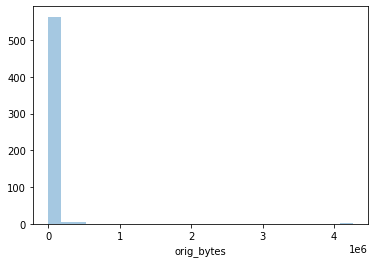

In [35]:
vis.histogram(bytes_from_host_day1.dropna(),'orig_bytes')

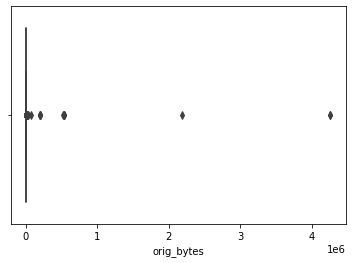

In [36]:
vis.box_plot(bytes_from_host_day1.dropna(),'orig_bytes')

Yeah, you are right... We need to filter our data!! 

In [37]:
bytes_from_host_day1 = spark.sql(
    '''
SELECT orig_bytes
FROM apt29NetworkDay1
WHERE orig_bytes <= 1500
                          ''')

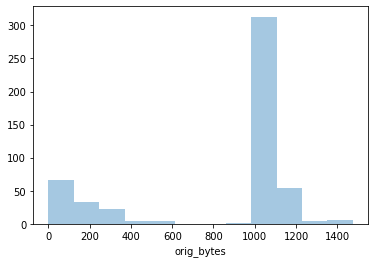

In [38]:
vis.histogram(bytes_from_host_day1.dropna(),'orig_bytes')

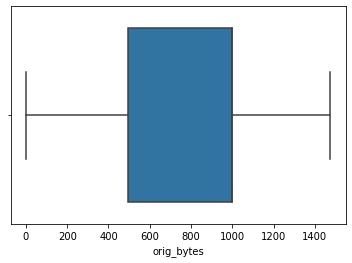

In [39]:
vis.box_plot(bytes_from_host_day1.dropna(),'orig_bytes')

Let's take a look at the **atipic** values for **bytes transfered**

In [40]:
bytes_from_host_day1 = spark.sql(
    '''
SELECT id_orig_h,id_orig_p,id_resp_h,id_resp_p, orig_bytes
FROM apt29NetworkDay1
WHERE (orig_bytes >= 1500 AND NOT orig_bytes LIKE 'NaN')

ORDER BY orig_bytes DESC
                          ''')
print(bytes_from_host_day1.count())
bytes_from_host_day1.show(truncate = False)

67
+---------+---------+-----------+---------+----------+
|id_orig_h|id_orig_p|id_resp_h  |id_resp_p|orig_bytes|
+---------+---------+-----------+---------+----------+
|10.0.1.4 |60803.0  |10.0.1.6   |445.0    |4261160.0 |
|10.0.1.4 |60803.0  |10.0.1.6   |445.0    |4261160.0 |
|10.0.1.4 |60760.0  |192.168.0.4|80.0     |2181167.0 |
|10.0.1.4 |60807.0  |10.0.1.6   |445.0    |527368.0  |
|10.0.1.4 |60807.0  |10.0.1.6   |445.0    |527368.0  |
|10.0.1.4 |60806.0  |10.0.1.6   |445.0    |527300.0  |
|10.0.1.4 |60806.0  |10.0.1.6   |445.0    |527300.0  |
|10.0.1.4 |60646.0  |192.168.0.5|443.0    |524399.0  |
|10.0.1.4 |60853.0  |10.0.1.6   |445.0    |193919.0  |
|10.0.1.4 |60853.0  |10.0.1.6   |445.0    |193919.0  |
|10.0.1.4 |60811.0  |10.0.1.6   |445.0    |193627.0  |
|10.0.1.4 |60824.0  |10.0.1.6   |445.0    |193627.0  |
|10.0.1.4 |60824.0  |10.0.1.6   |445.0    |193627.0  |
|10.0.1.4 |60811.0  |10.0.1.6   |445.0    |193627.0  |
|10.0.1.4 |60597.0  |192.168.0.5|1234.0   |70042.0   |
|10.0.1

How can we **correlate** **network** and **host** data?

In [41]:
sysmon3_host_day1 = spark.sql(
    '''
SELECT ProcessId, User, Image, SourcePort, DestinationPort
FROM apt29HostDay1
WHERE Channel = 'Microsoft-Windows-Sysmon/Operational'
    AND EventID = 3
    AND SourceIp LIKE "%10.0.1.4%"
    AND DestinationIp LIKE "%192.168.0.4%"
                          ''')
print(sysmon3_host_day1.count())
sysmon3_host_day1.show(truncate = False)

8
+---------+--------------------------+---------------------------------------------------------+----------+---------------+
|ProcessId|User                      |Image                                                    |SourcePort|DestinationPort|
+---------+--------------------------+---------------------------------------------------------+----------+---------------+
|3852     |DMEVALS\pbeesly           |C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe|59941     |80             |
|8984     |NT AUTHORITY\LOCAL SERVICE|C:\Windows\System32\svchost.exe                          |59942     |80             |
|8984     |NT AUTHORITY\LOCAL SERVICE|C:\Windows\System32\svchost.exe                          |59943     |80             |
|8984     |NT AUTHORITY\LOCAL SERVICE|C:\Windows\System32\svchost.exe                          |59964     |80             |
|8984     |NT AUTHORITY\LOCAL SERVICE|C:\Windows\System32\svchost.exe                          |59965     |80             |
|8984 

# Thank you !!!